In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
churn_data = pd.read_csv('../files/raw_BankChurners.csv')

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

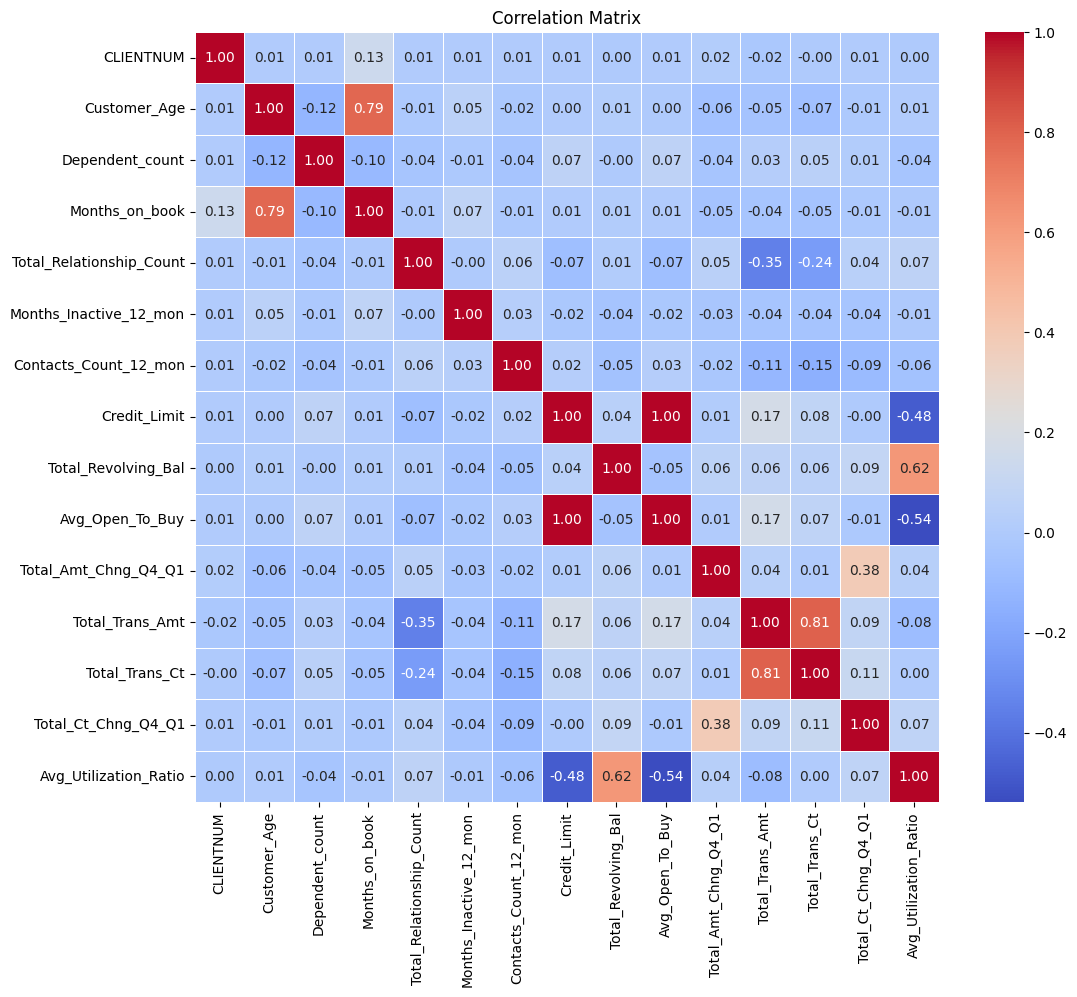

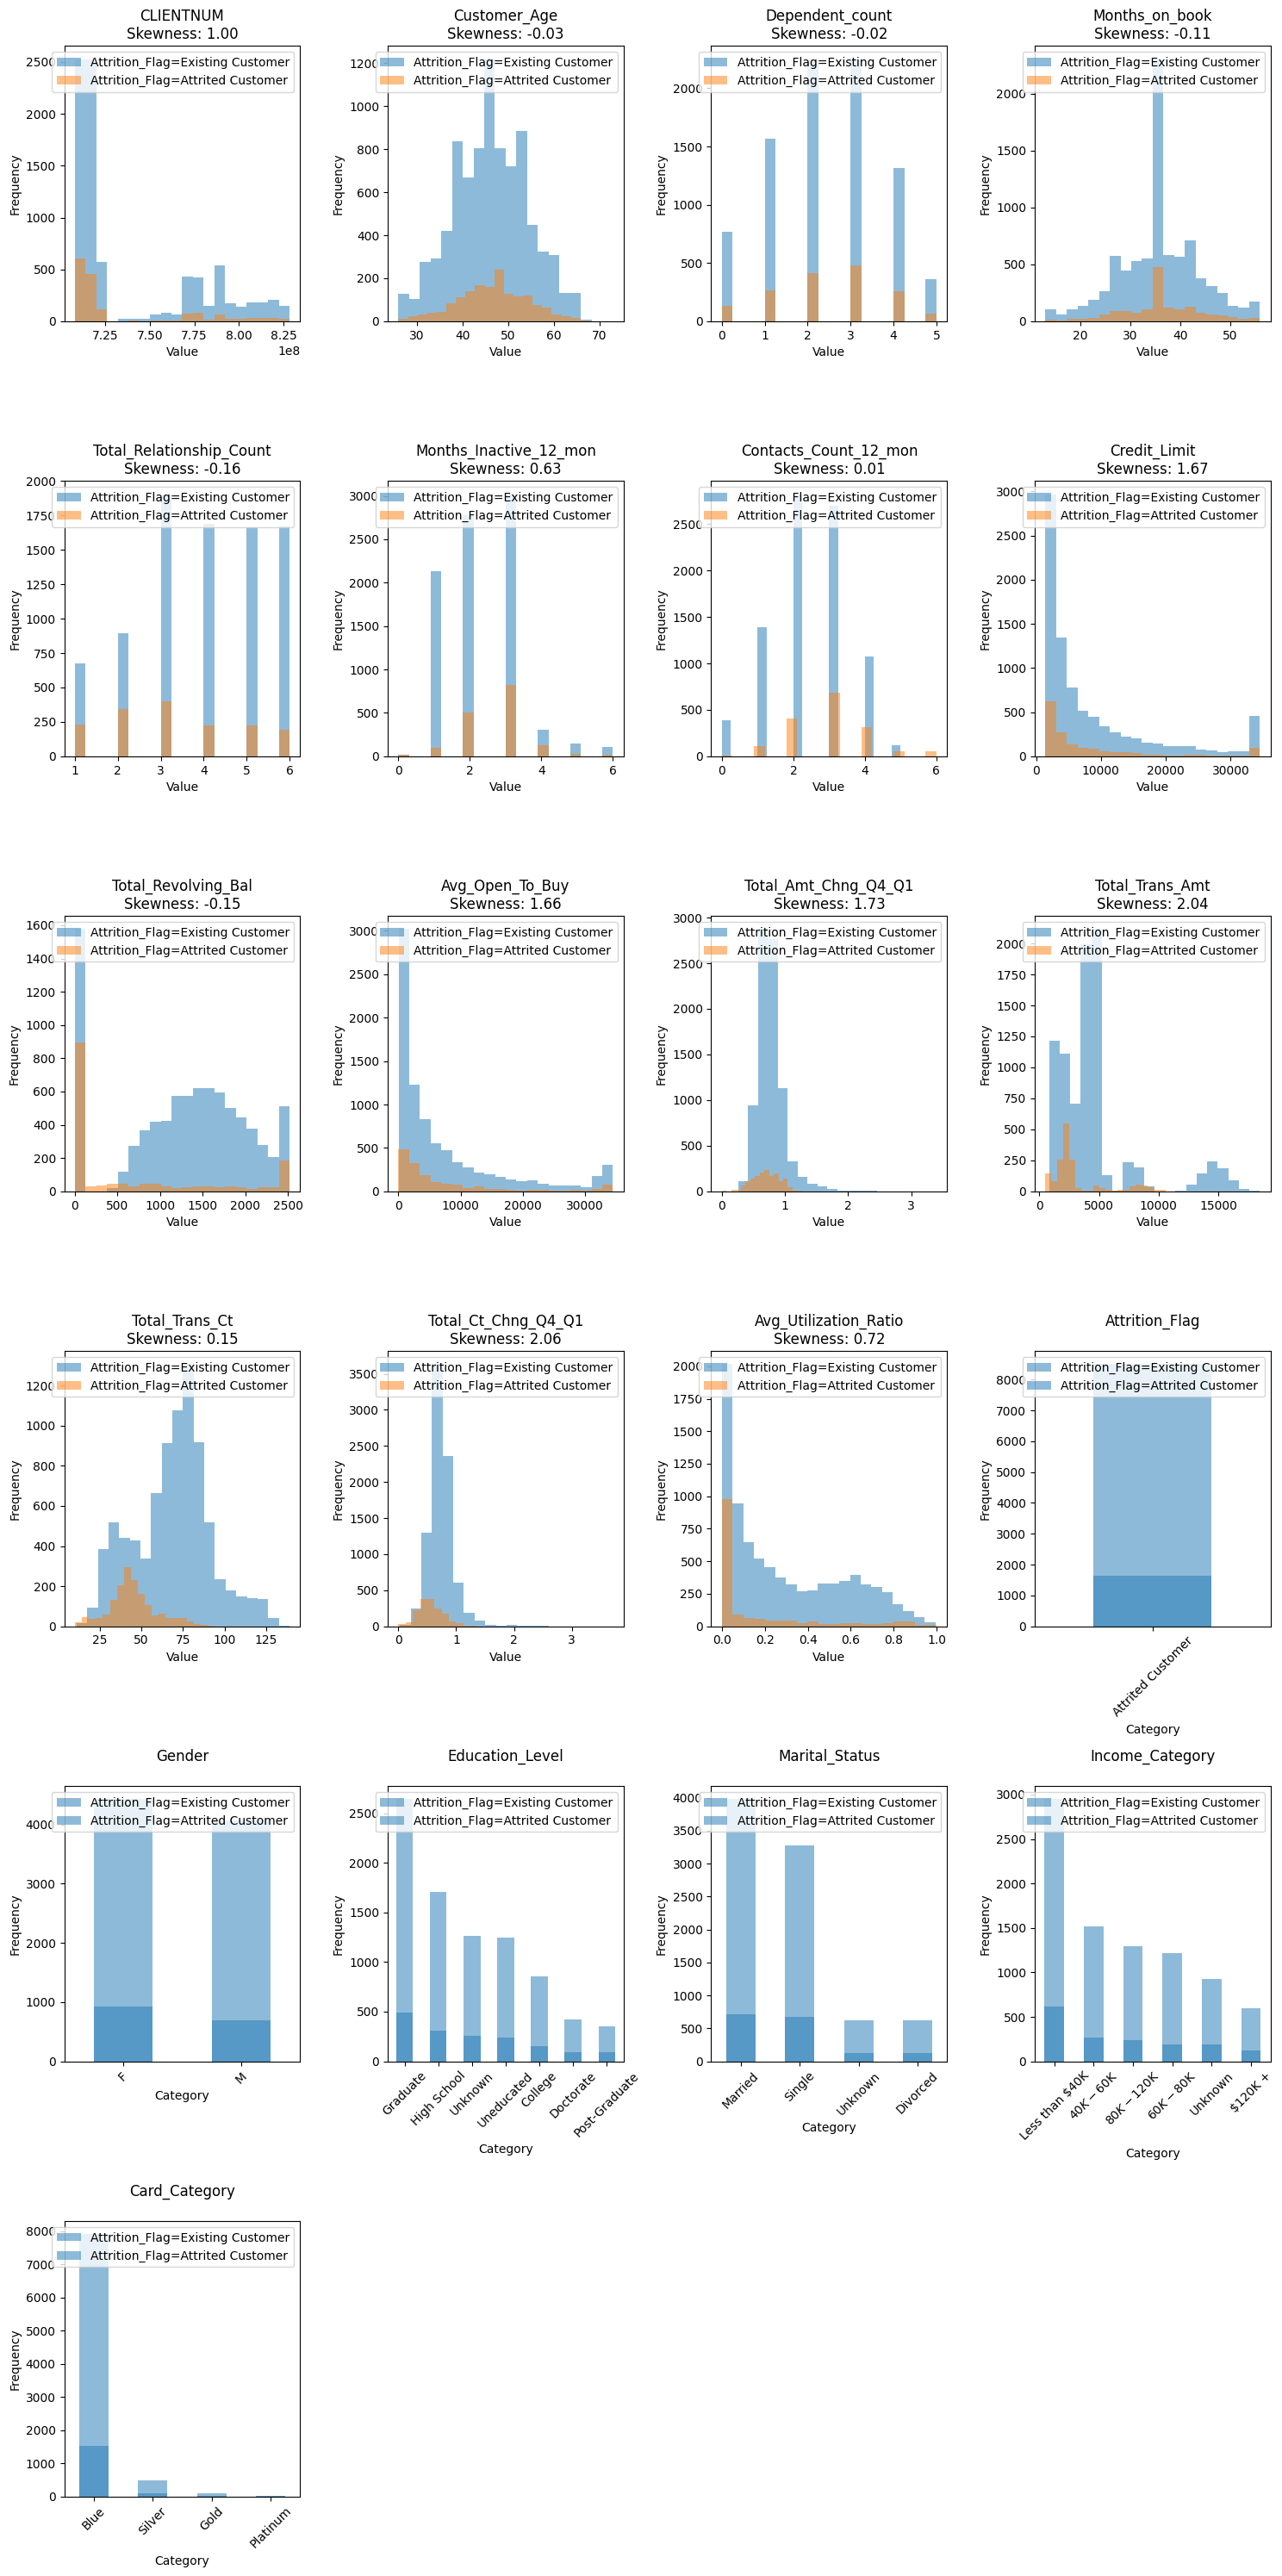

In [3]:
# Create analysis functions
def plot_correlation_matrix(data):
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = data[numeric_columns].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

import math

def plot_histograms_with_skewness(data, target_variable):
    num_columns = len(data.columns)
    num_rows = math.ceil(num_columns / 4)
    plt.figure(figsize=(15, 5 * num_rows))
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    # Plot histograms for numerical columns grouped by target variable
    for i, column in enumerate(numerical_columns):
        plt.subplot(num_rows, 4, i + 1)
        for target_value in data[target_variable].unique():
            data[data[target_variable] == target_value][column].hist(bins=20, alpha=0.5, label=f"{target_variable}={target_value}")
        plt.title(f"{column}\nSkewness: {data[column].skew():.2f}")
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(False)
        plt.legend()
    
    # Plot bar plots for categorical columns grouped by target variable
    for i, column in enumerate(categorical_columns, start=len(numerical_columns)):
        plt.subplot(num_rows, 4, i + 1)
        for target_value in data[target_variable].unique():
            data[data[target_variable] == target_value][column].value_counts().plot(kind='bar', alpha=0.5, label=f"{target_variable}={target_value}")
        plt.title(f"{column}\n")
        plt.xlabel('Category')
        plt.ylabel('Frequency')
        plt.grid(False)
        plt.xticks(rotation=45)
        plt.legend()
    
    plt.tight_layout()
    plt.show()


churn_data = churn_data.iloc[:, :-2]

# Plot correlation matrix  and histograms
plot_correlation_matrix(churn_data)
plot_histograms_with_skewness(churn_data, 'Attrition_Flag')

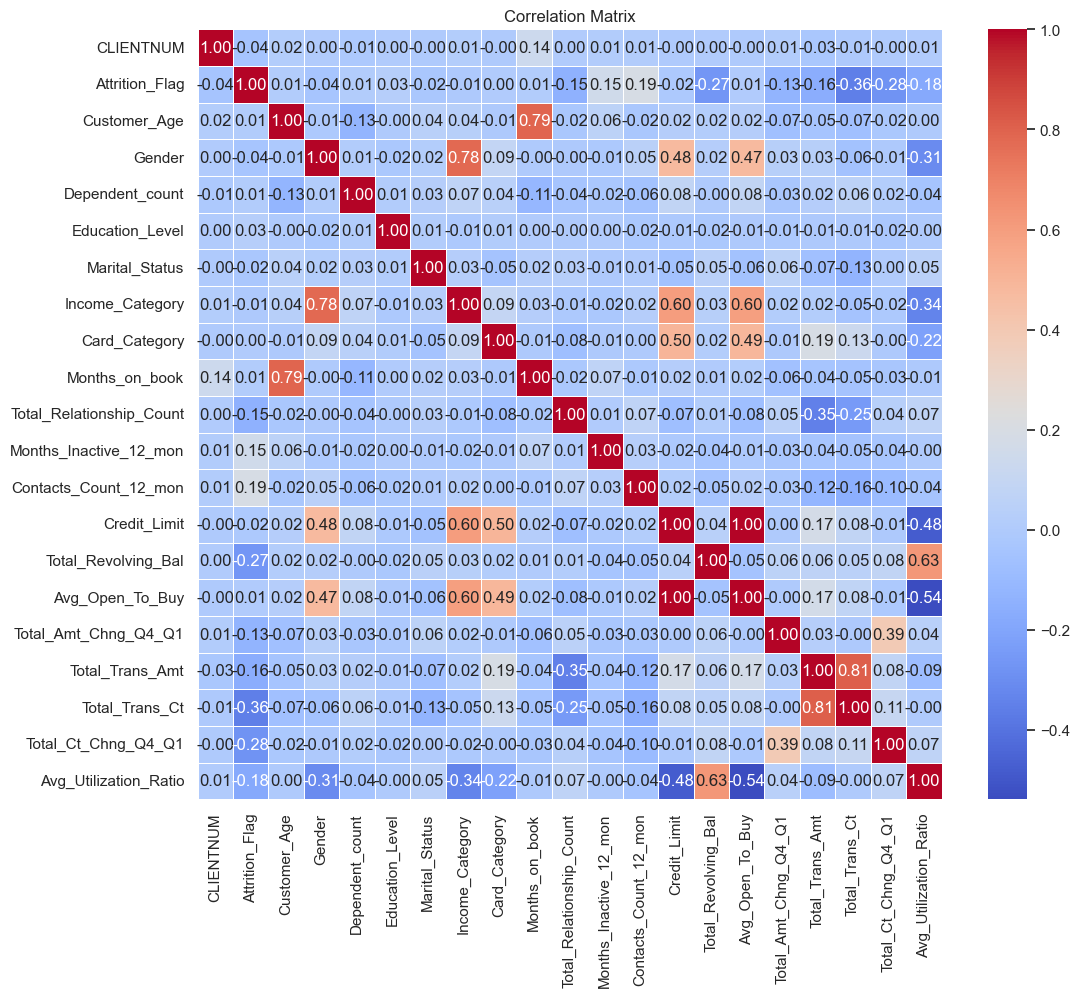

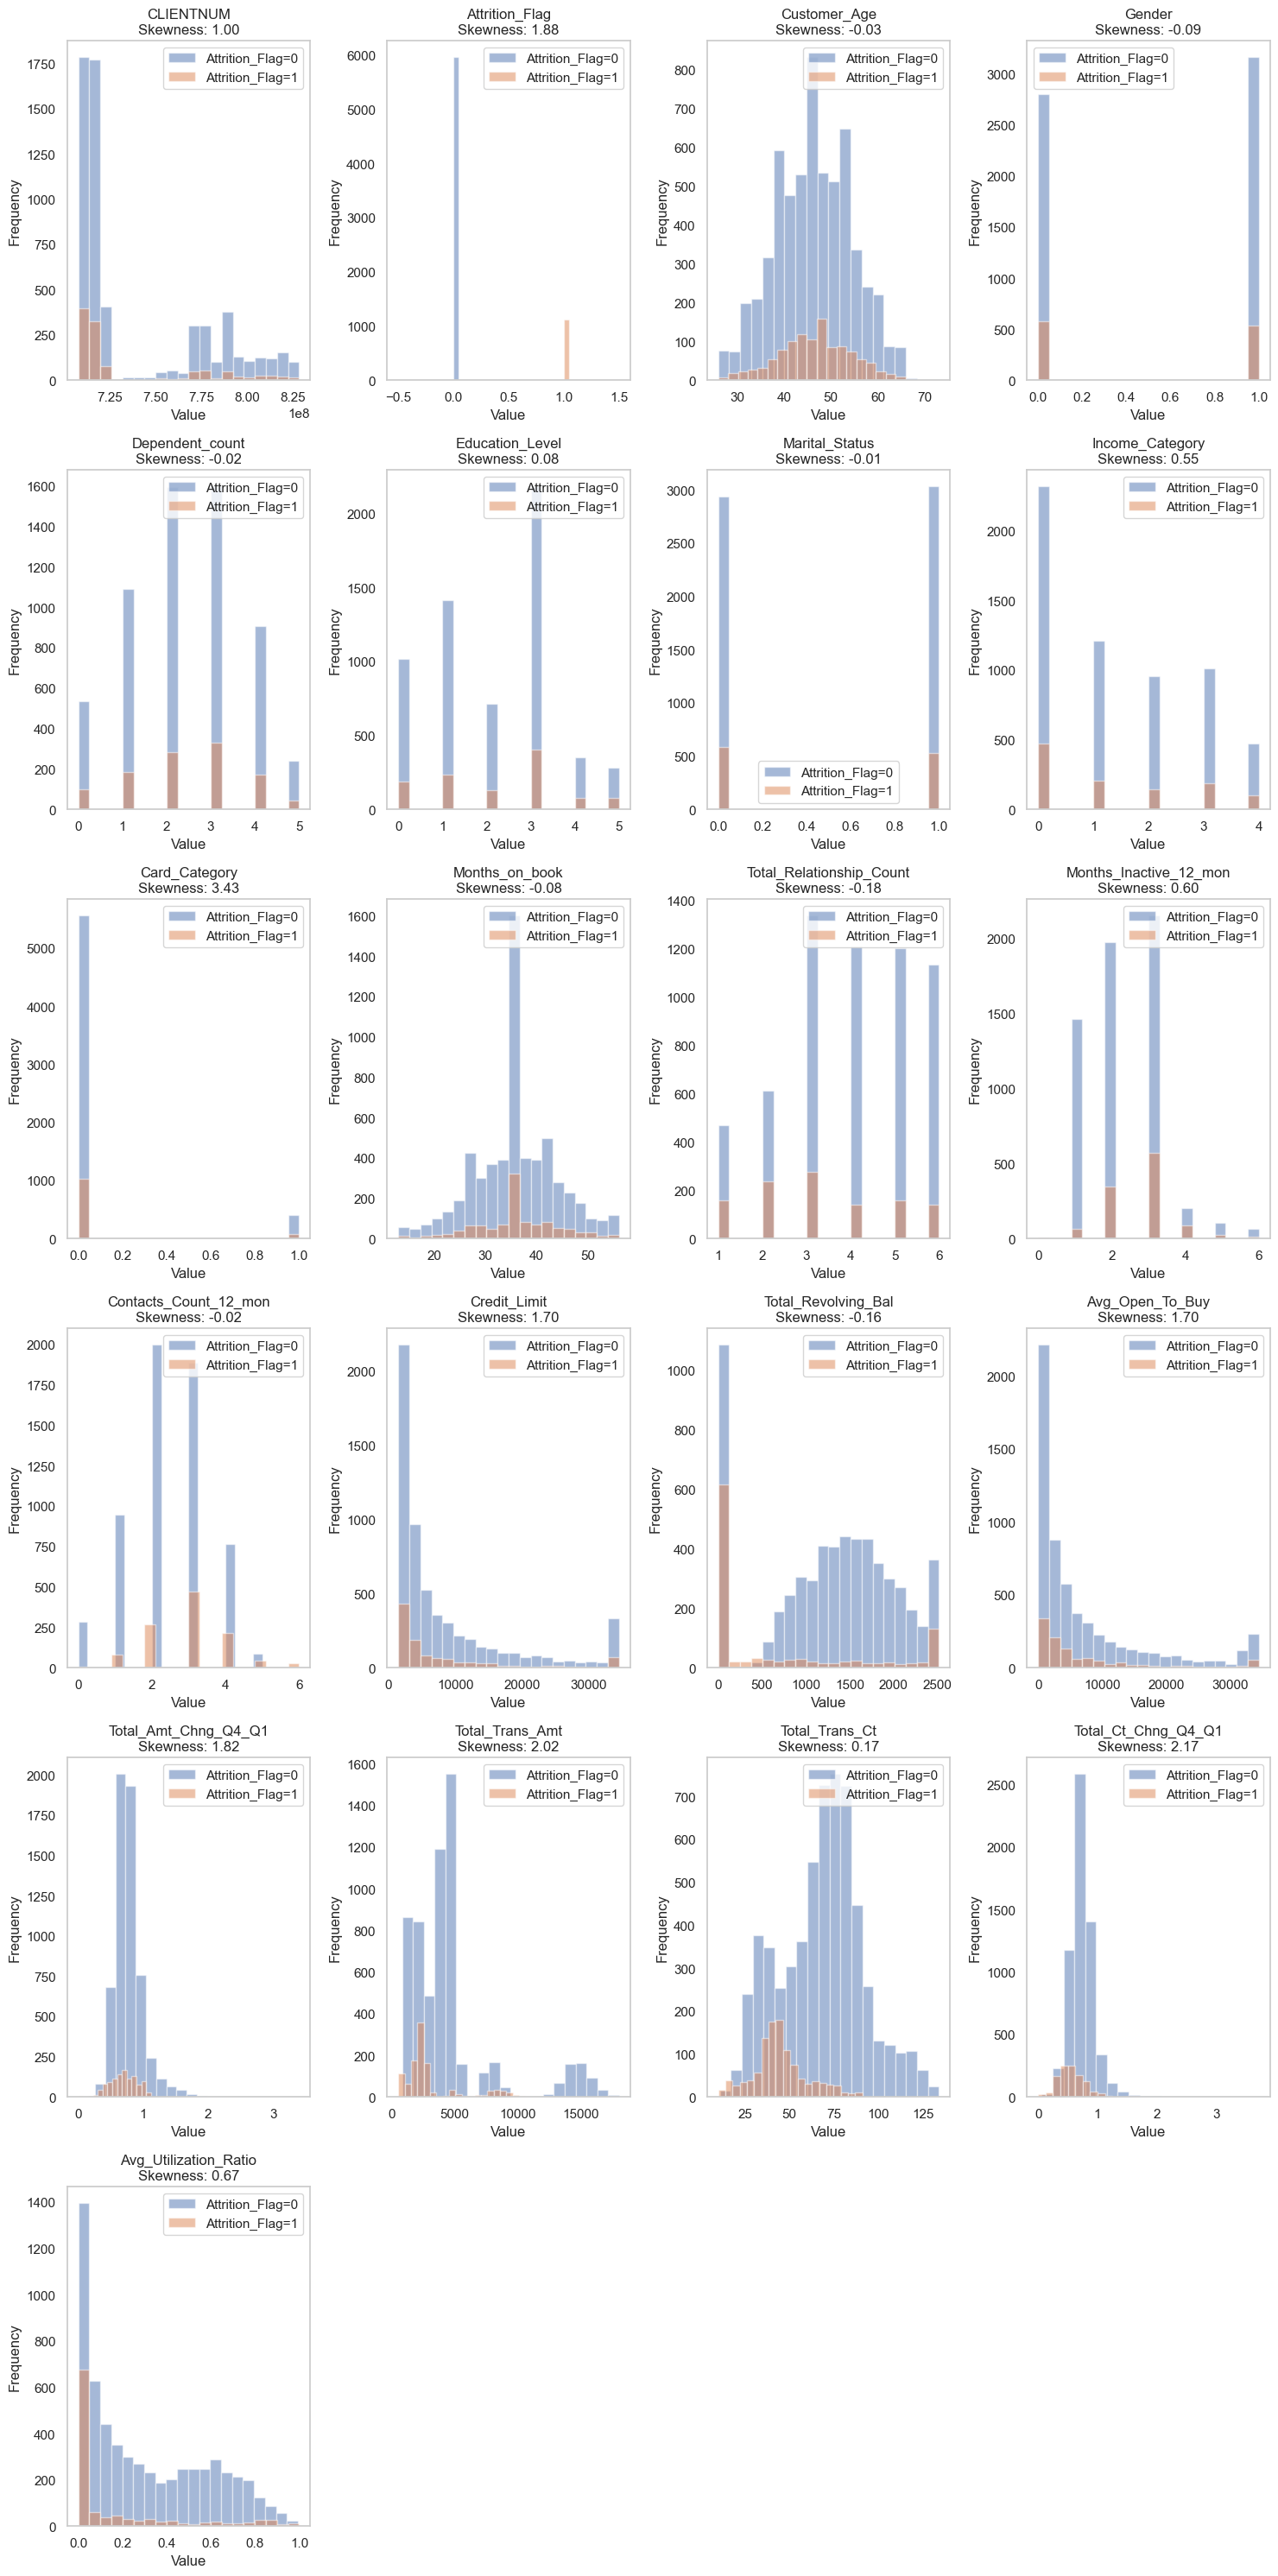

In [16]:
def label_encode_columns(data, encoding_dicts):
    encoded_data = data.copy()
    for column, encoder_dict in encoding_dicts.items():
        encoded_data[column] = encoded_data[column].map(encoder_dict)
    return encoded_data

# Original unique values for object columns
original_unique_values = {
    'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
    'Gender': ['M', 'F'],
    'Education_Level': ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate'],
    'Marital_Status': ['Married', 'Single', 'Unknown', 'Divorced'],
    'Income_Category': ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown'],
    'Card_Category': ['Blue', 'Gold', 'Silver', 'Platinum']
}

# Encoding dictionaries
encoding_dicts = {
    'Attrition_Flag': {'Existing Customer': 0, 'Attrited Customer': 1},
    'Gender': {'M': 1, 'F': 0},
    'Education_Level': {'High School': 1, 'Graduate': 3, 'Uneducated': 0, 'Unknown': -1, 'College': 2, 'Post-Graduate': 4, 'Doctorate': 5},
    'Marital_Status': {'Married': 1, 'Single': 0, 'Unknown': -1, 'Divorced': 0},
    'Income_Category': {'$60K - $80K': 2, 'Less than $40K': 0, '$80K - $120K': 3, '$40K - $60K': 1, '$120K +': 4, 'Unknown': -1},
    'Card_Category': {'Blue': 0, 'Gold': 1, 'Silver': 1, 'Platinum': 1}
}

# Apply label encoding
encoded_data = label_encode_columns(churn_data, encoding_dicts)
encoded_data = encoded_data.drop(encoded_data[(encoded_data < 0).any(axis=1)].index)

# Plot correlation matrix for numeric columns
plot_correlation_matrix(encoded_data)
plot_histograms_with_skewness(encoded_data, 'Attrition_Flag')

In [18]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7081 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 7081 non-null   int64  
 1   Attrition_Flag            7081 non-null   int64  
 2   Customer_Age              7081 non-null   int64  
 3   Gender                    7081 non-null   int64  
 4   Dependent_count           7081 non-null   int64  
 5   Education_Level           7081 non-null   int64  
 6   Marital_Status            7081 non-null   int64  
 7   Income_Category           7081 non-null   int64  
 8   Card_Category             7081 non-null   int64  
 9   Months_on_book            7081 non-null   int64  
 10  Total_Relationship_Count  7081 non-null   int64  
 11  Months_Inactive_12_mon    7081 non-null   int64  
 12  Contacts_Count_12_mon     7081 non-null   int64  
 13  Credit_Limit              7081 non-null   float64
 14  Total_Revolv

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Split the DataFrame into features (X) and target (y)
X = encoded_data.drop(columns=['Attrition_Flag'])  # Exclude the target column
y = encoded_data['Attrition_Flag']

# Step 2: Dimensionality Reduction with PCA
# Choose the number of components you want to keep
n_components = 10  # Example number, you can adjust this
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Step 3: Feature Selection with SelectKBest
# Choose the number of features you want to select
k_features = 5  # Example number, you can adjust this
selector = SelectKBest(score_func=f_classif, k=k_features)
X_selected = selector.fit_transform(X, y)

# Print the selected features
selected_features = X.columns[selector.get_support(indices=True)].tolist()
print("Selected Features:", selected_features)

# You can also access feature scores to see their importance
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print("Feature Scores:\n", feature_scores)

# Now you have X_pca (PCA-transformed features) and X_selected (selected features)


Selected Features: ['Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
Feature Scores:
                      Feature        Score
17            Total_Trans_Ct  1035.727051
18       Total_Ct_Chng_Q4_Q1   604.355668
13       Total_Revolving_Bal   536.320369
11     Contacts_Count_12_mon   276.614784
19     Avg_Utilization_Ratio   248.020890
16           Total_Trans_Amt   186.885859
10    Months_Inactive_12_mon   169.076373
9   Total_Relationship_Count   153.563890
15      Total_Amt_Chng_Q4_Q1   126.894779
0                  CLIENTNUM    11.939324
2                     Gender     8.860973
4            Education_Level     5.705899
5             Marital_Status     4.150659
12              Credit_Limit     1.771077
3            Dependent_count     0.923763
8             Months_on_book     0.605624
1               Customer_Age     0.540195
14           Avg_Open_To_Buy     0.430916
6            Income_Category     0.395189
7        

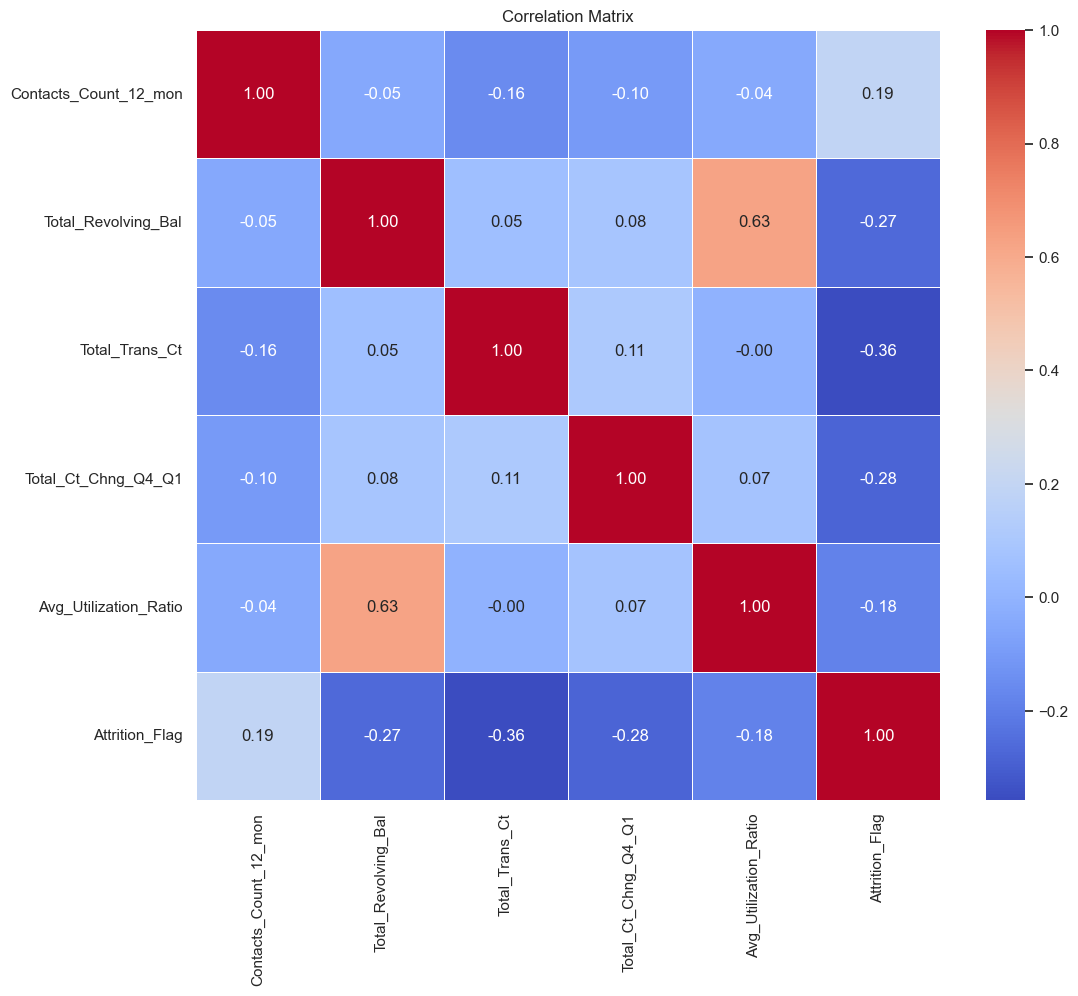

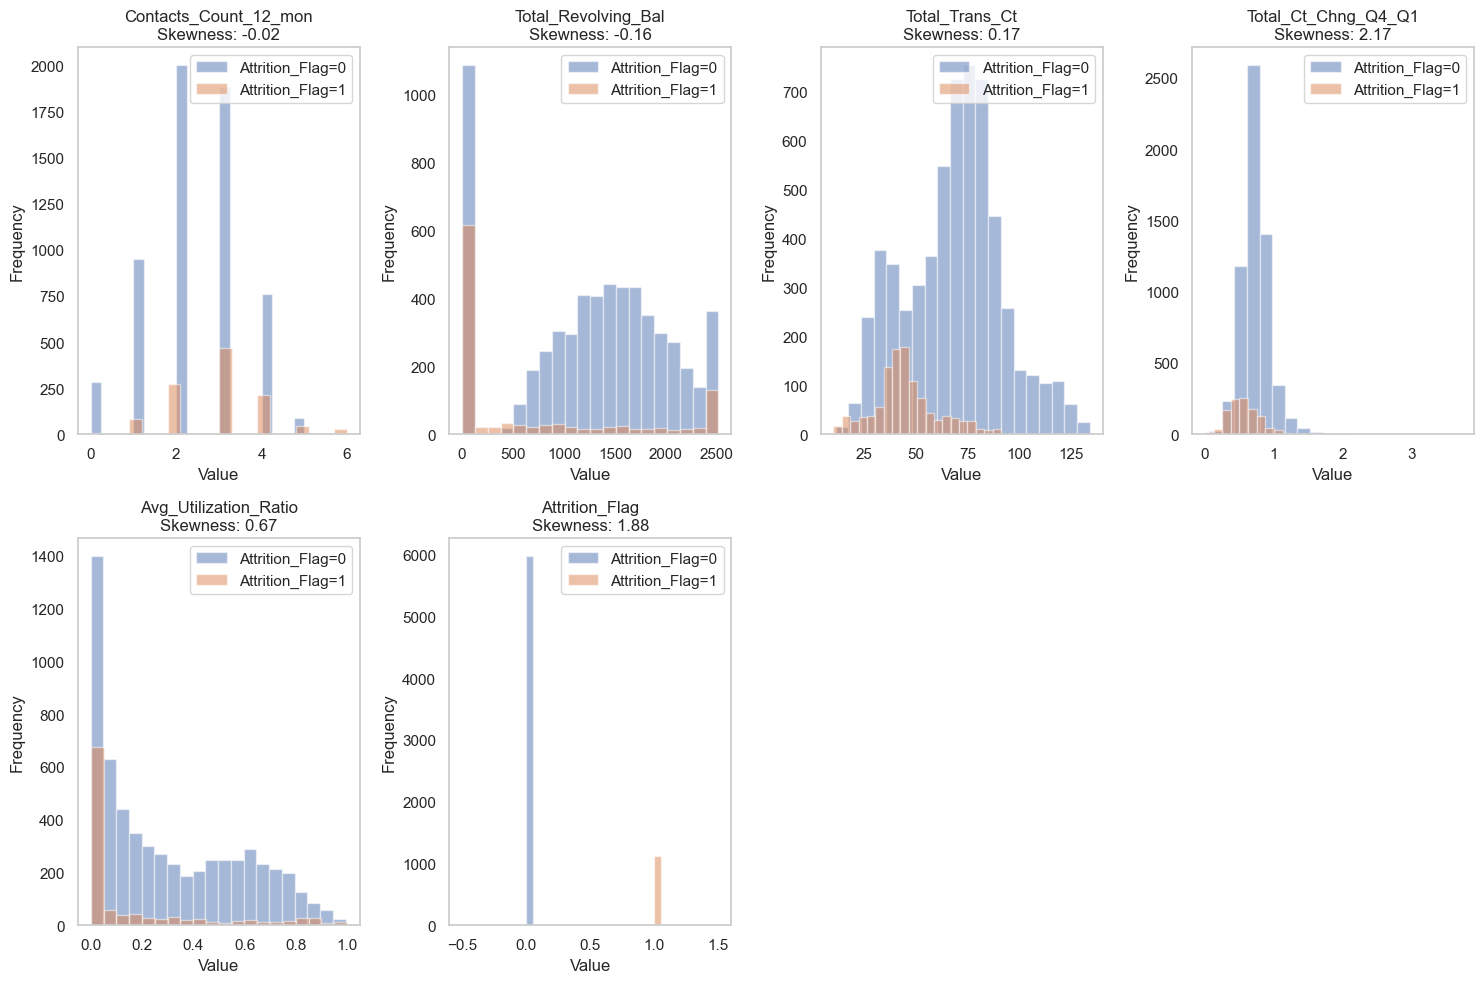

In [20]:
# Combine selected features with the target variable
selected_data = encoded_data[selected_features + ['Attrition_Flag']]

# Plot correlation matrix of selected features with the target variable
plot_correlation_matrix(selected_data)
plot_histograms_with_skewness(selected_data, 'Attrition_Flag')

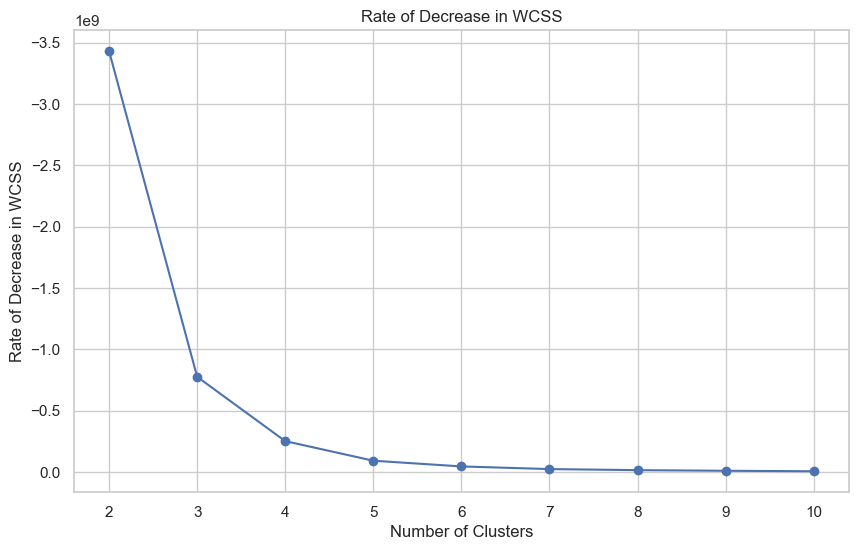

In [21]:
from sklearn.cluster import KMeans
import numpy as np

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(selected_data)
    wcss.append(kmeans.inertia_)

# Calculate the rate of decrease in WCSS
wcss_diff = np.diff(wcss)

# Plot the rate of decrease in WCSS
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss_diff, marker='o', linestyle='-', color='b')  # Adjusted x-axis range
plt.title('Rate of Decrease in WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('Rate of Decrease in WCSS')
plt.gca().invert_yaxis()  # Invert y-axis
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


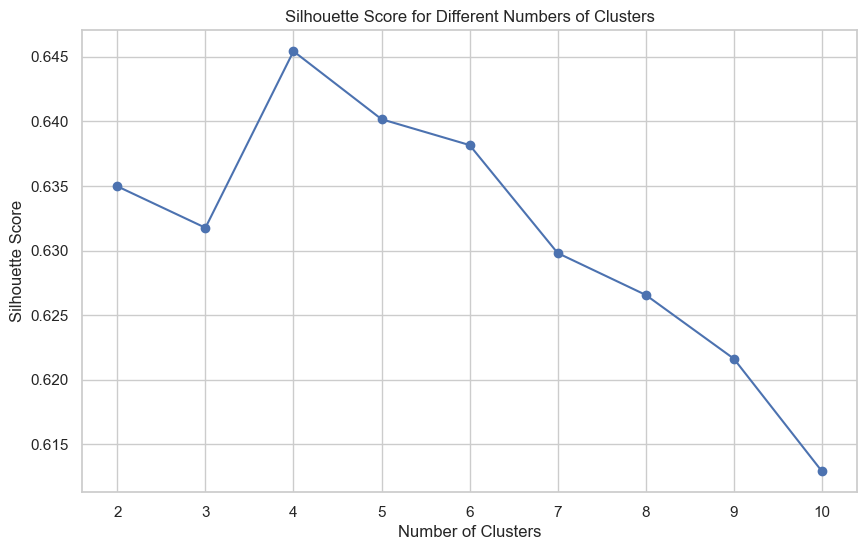

Optimal number of clusters: 4


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming you have already performed dimensionality reduction and feature selection

# Range of clusters to test
clusters_range = range(2, 11)  # Start from 2 clusters since silhouette score requires at least two clusters
silhouette_scores = []

# Calculate silhouette score for each number of clusters
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(selected_data)
    silhouette_avg = silhouette_score(selected_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters with the highest silhouette score
optimal_num_clusters = clusters_range[np.argmax(silhouette_scores)]

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters_range)
plt.grid(True)
plt.show()

print("Optimal number of clusters:", optimal_num_clusters)

C:\Users\bearr\AppData\Local\Temp\ipykernel_3888\3019795183.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Cluster'] = cluster_labels


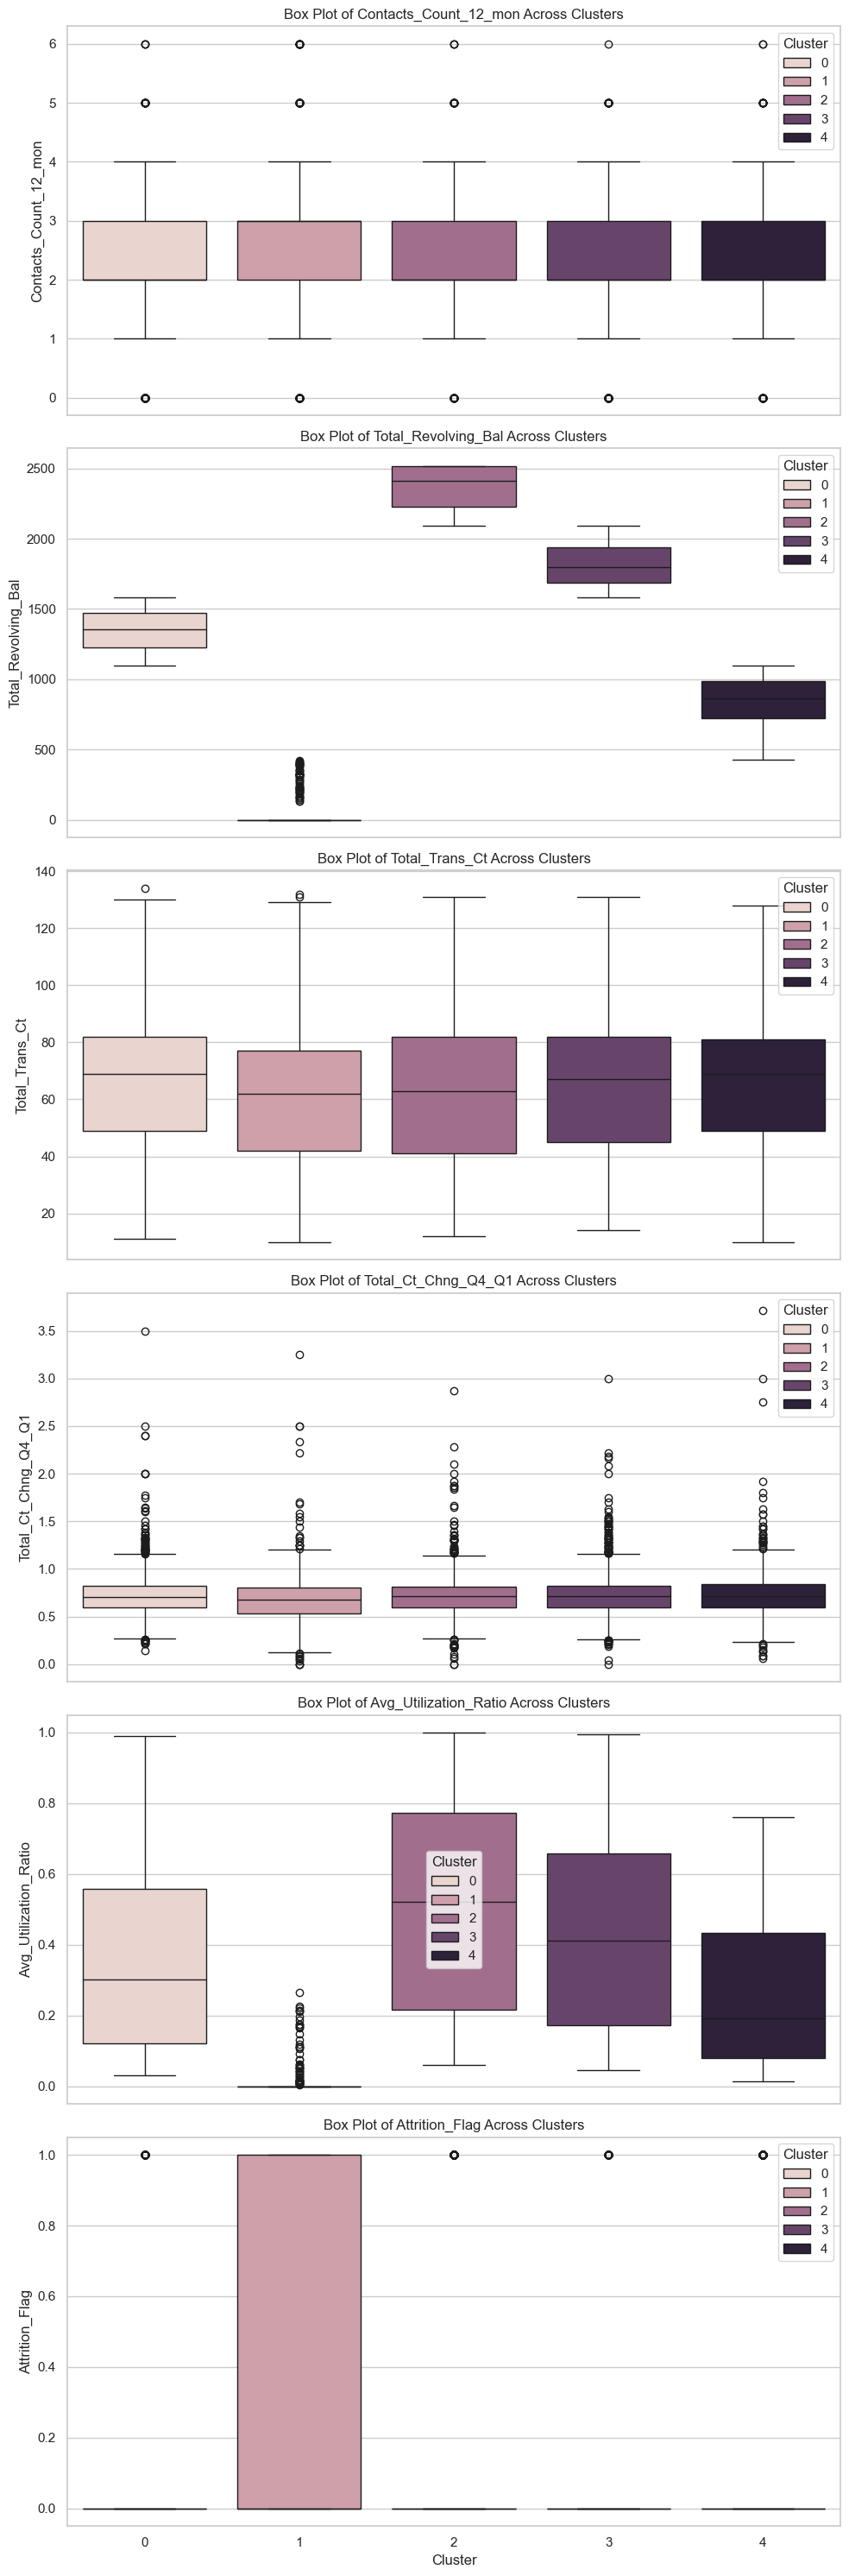

In [23]:
import seaborn as sns

# Define the number of clusters
num_clusters = 5

# Initialize KMeans with the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans to the selected data
cluster_labels = kmeans.fit_predict(selected_data)

# Add cluster labels to the selected data DataFrame
selected_data['Cluster'] = cluster_labels

# Set the style of seaborn
sns.set(style="whitegrid")

# Define the number of rows for subplots (including the target variable)
num_rows = selected_data.shape[1] - 1  # Subtract 1 for the Cluster column

# Create subplots
fig, axes = plt.subplots(num_rows, 1, figsize=(10, 5*num_rows), sharex=True)

# Plot box plots for each feature
for i, feature in enumerate(selected_data.columns[:-1]):  # Exclude the last column (Cluster)
    sns.boxplot(x='Cluster', y=feature, data=selected_data, ax=axes[i], hue='Cluster', dodge=False)
    axes[i].set_title(f'Box Plot of {feature} Across Clusters')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

Cluster Summary (Mean Values for Each Feature):
Cluster                      0      1        2        3       4
Contacts_Count_12_mon     2.37   2.60     2.46     2.42    2.40
Total_Revolving_Bal    1350.12   8.71  2369.01  1814.70  841.61
Total_Trans_Ct           67.32  60.62    63.04    65.68   65.97
Total_Ct_Chng_Q4_Q1       0.72   0.67     0.72     0.73    0.72
Avg_Utilization_Ratio     0.35   0.00     0.50     0.42    0.25
Attrition_Flag            0.04   0.38     0.18     0.04    0.12


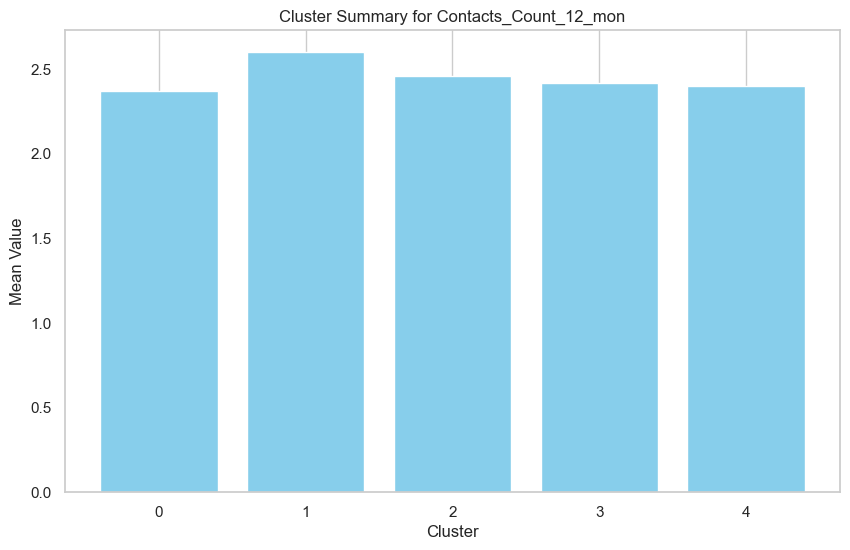

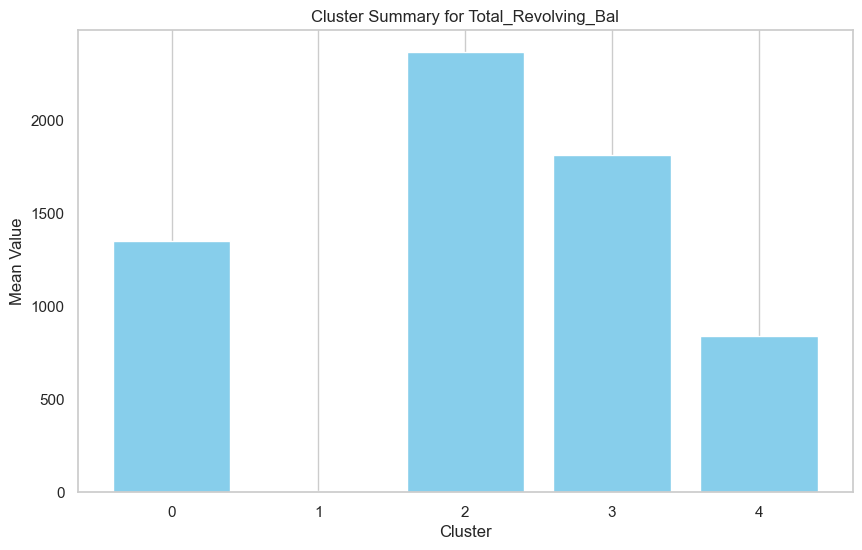

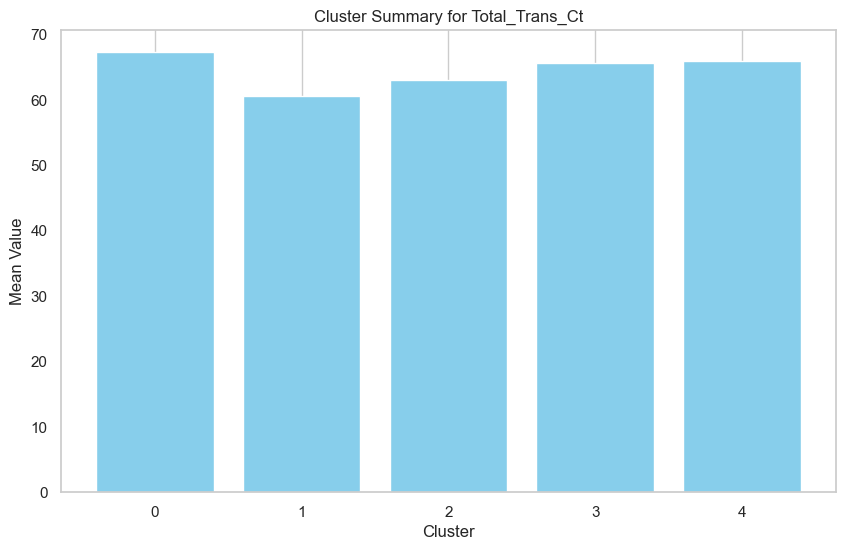

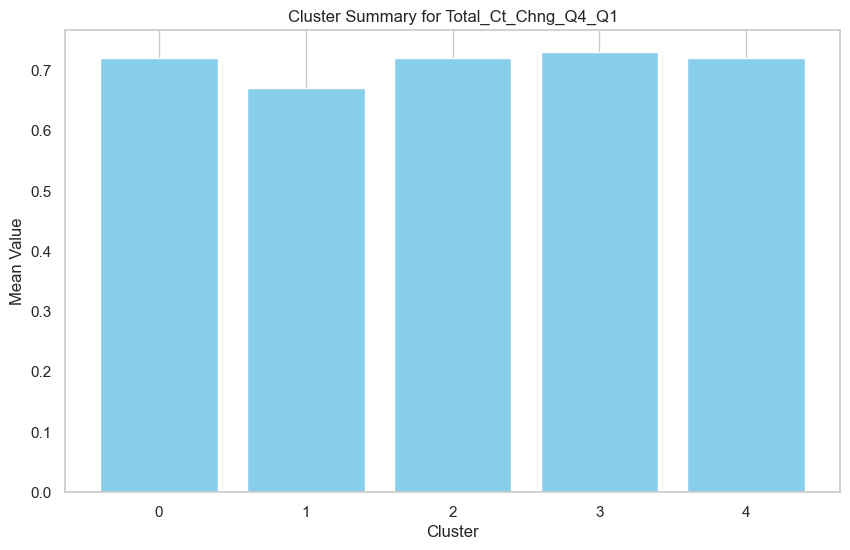

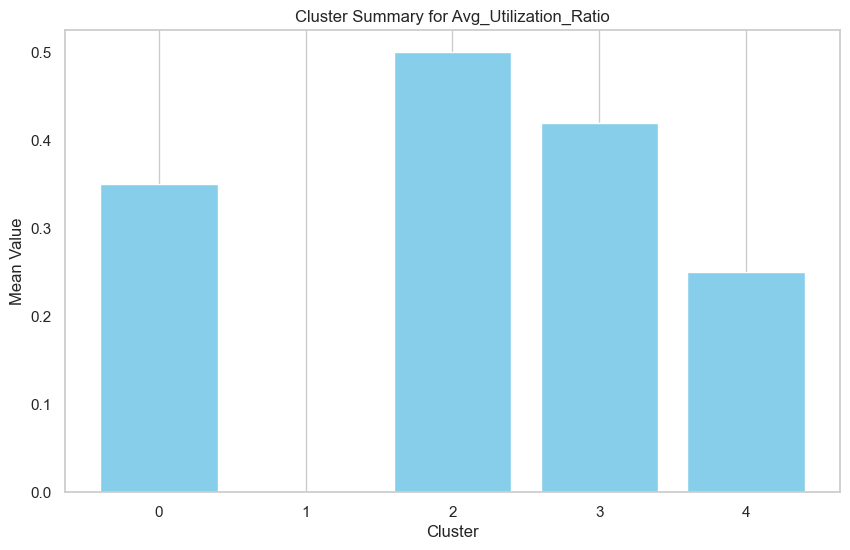

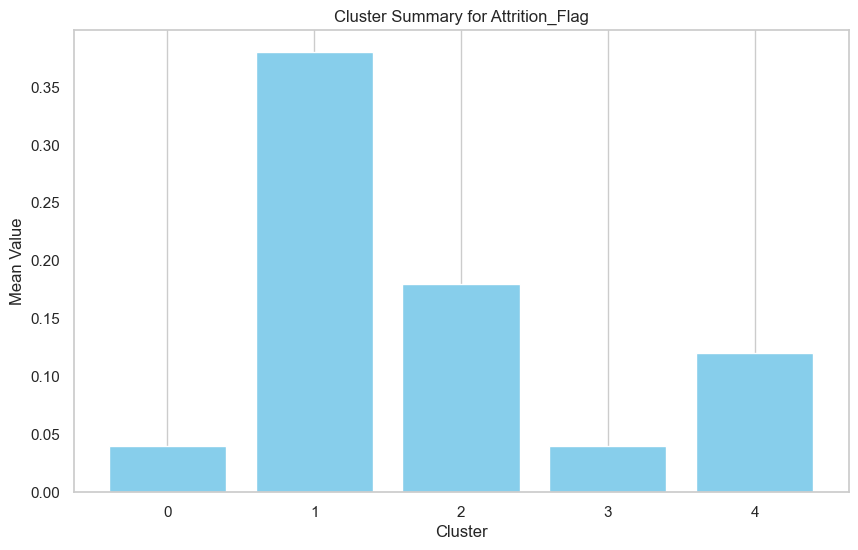

In [26]:
# Calculate median values for each feature within each cluster
cluster_summary = selected_data.groupby('Cluster').mean().round(2)

# Transpose the DataFrame to switch rows and columns
cluster_summary_transposed = cluster_summary.transpose()

# Print the transposed summary
print("Cluster Summary (Mean Values for Each Feature):")
print(cluster_summary_transposed)
for feature in cluster_summary_transposed.index:
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_summary_transposed.columns, cluster_summary_transposed.loc[feature], color='skyblue')
    plt.title(f'Cluster Summary for {feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Mean Value')
    plt.xticks(cluster_summary_transposed.columns)
    plt.grid(axis='y')
    plt.show()

Cluster Summary (Median Values for Each Feature):
Cluster                      0      1        2        3       4
Contacts_Count_12_mon     2.00   3.00     2.00     2.00    2.00
Total_Revolving_Bal    1352.50   0.00  2413.00  1799.50  866.50
Total_Trans_Ct           69.00  62.00    63.00    67.00   69.00
Total_Ct_Chng_Q4_Q1       0.71   0.67     0.71     0.71    0.71
Avg_Utilization_Ratio     0.30   0.00     0.52     0.41    0.19
Attrition_Flag            0.00   0.00     0.00     0.00    0.00


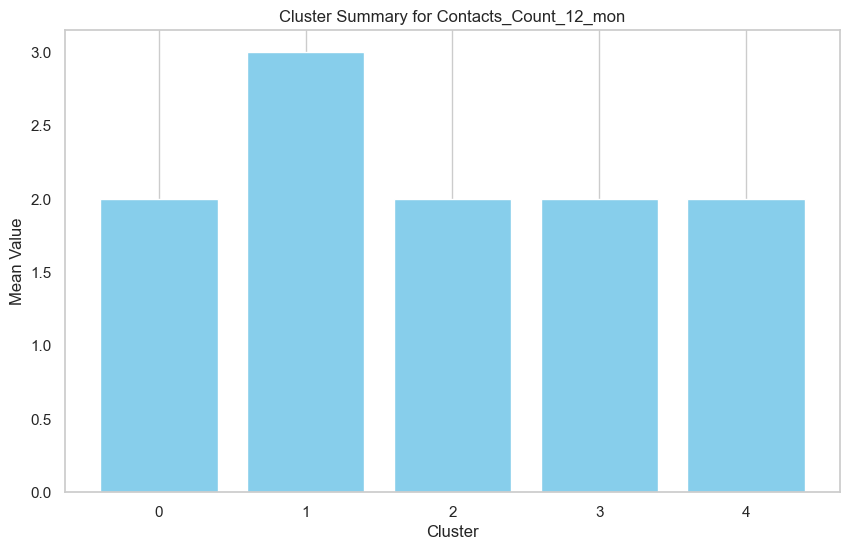

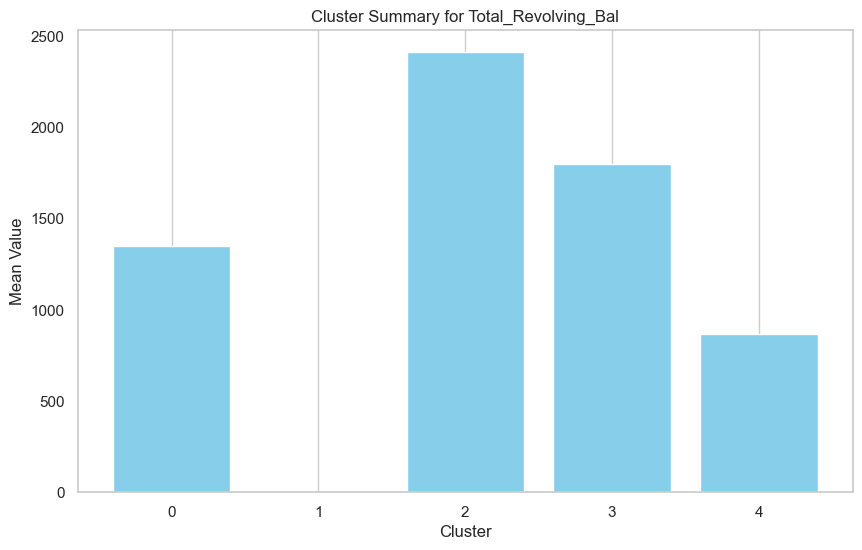

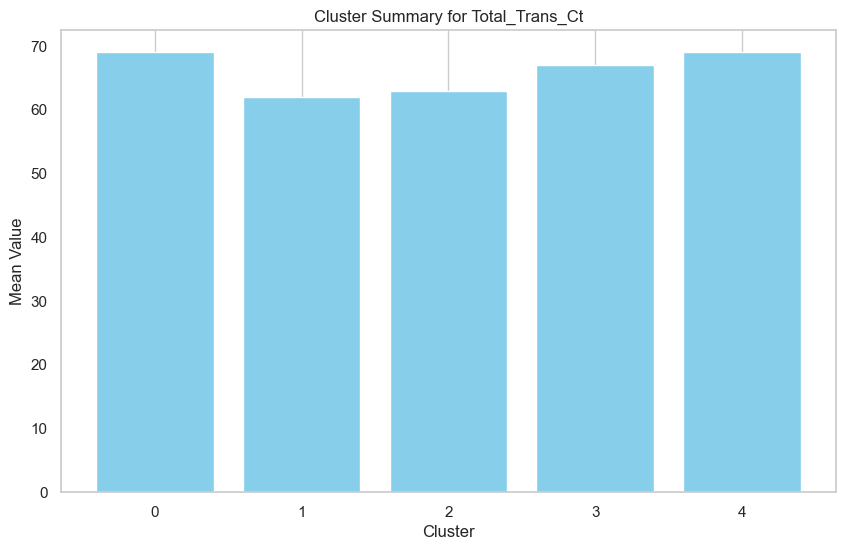

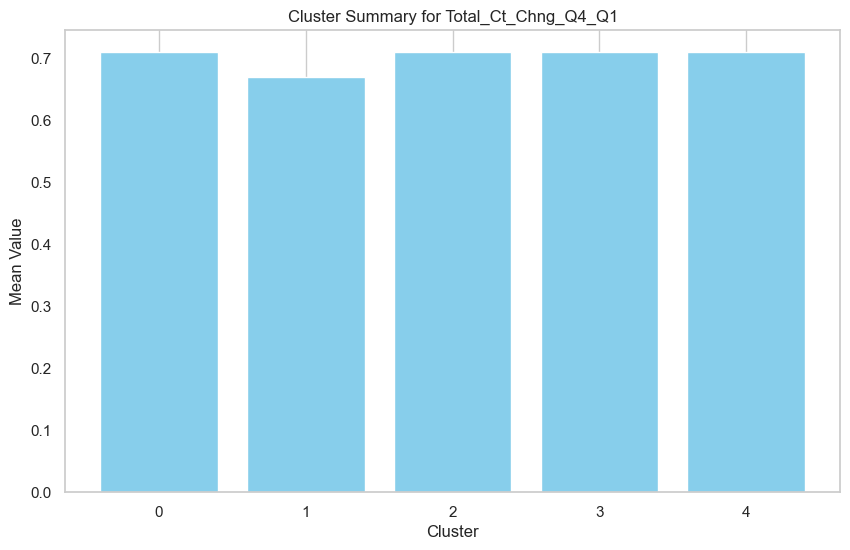

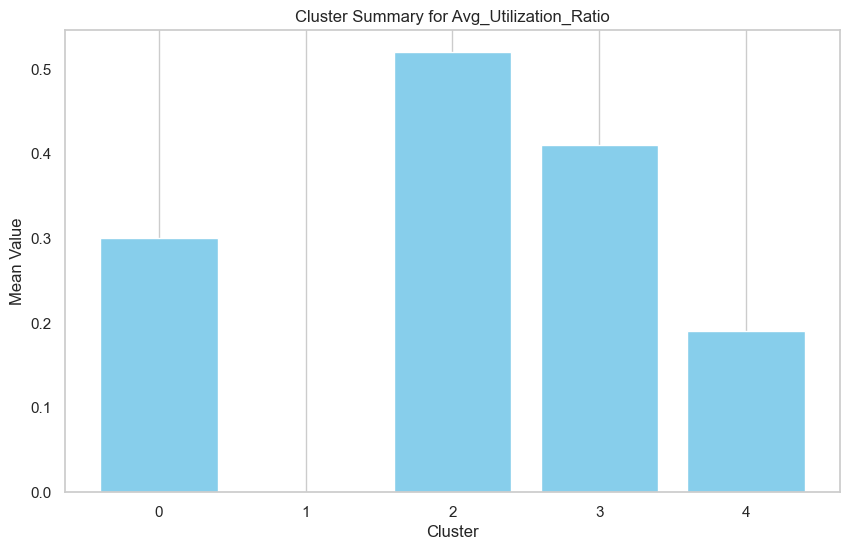

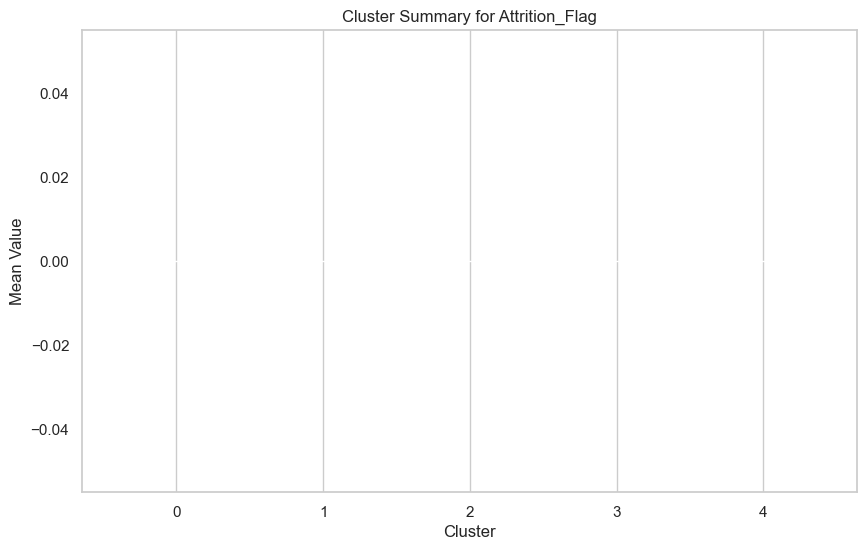

In [25]:
# Calculate median values for each feature within each cluster
cluster_summary = selected_data.groupby('Cluster').median().round(2)

# Transpose the DataFrame to switch rows and columns
cluster_summary_transposed = cluster_summary.transpose()

# Print the transposed summary
print("Cluster Summary (Median Values for Each Feature):")
print(cluster_summary_transposed)

for feature in cluster_summary_transposed.index:
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_summary_transposed.columns, cluster_summary_transposed.loc[feature], color='skyblue')
    plt.title(f'Cluster Summary for {feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Mean Value')
    plt.xticks(cluster_summary_transposed.columns)
    plt.grid(axis='y')
    plt.show()